In [1]:
%matplotlib widget 

import numpy as np
import h5py
import matplotlib.pyplot as plt

import sscCdi
sscCdi.__version__

'0.10.0'

Object pixel = 1e-07 m
Probe shape = (2048, 2048)
Size of the array: 0.125 GB
Object shape = (2266, 2276)
Data shape = (16, 2048, 2048)
Positions shape = (16, 2)


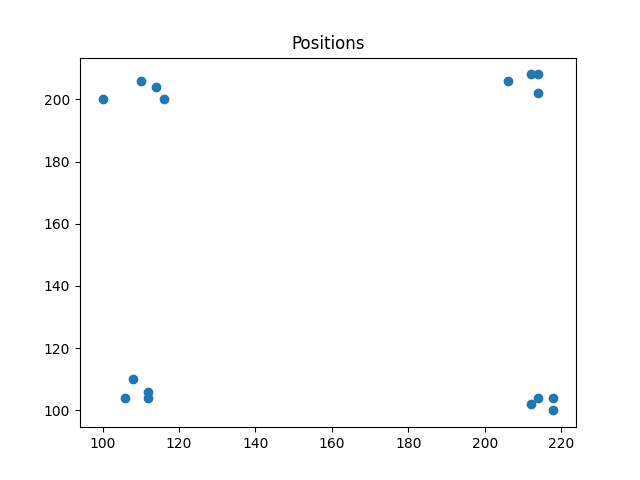

In [10]:
with h5py.File('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho_fresnel/Ptycho-id16-NFP/ID16_Siemens_YuriFormat.h5','r') as file:
    DPs = file['DPs'][()]
    positions = file['positions'][()].T
    energy = file['energy'][()]
    wavelength = file['wavelength'][()]
    pixel_size_detector = file['effective_pixel_detector'][()] 
    detector_distance = file['effective_detector_distance'][()]
    z1 = file['z1'][()]
    z2 = file['z2'][()]
    dark = file['dark'][()]
    
c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
n_pixels = 2048

magnification = (z1+z2)/z1

inputs = {
"n_cpus": 32, # cpu cores
"energy": energy, #keV
"detector_distance": z2/magnification, # meter
"distance": z2/magnification, # meter
"detector_pixel_size": pixel_size_detector,
"source_distance": 0, # should be 0 if parallel beam
}


# inputs["detector_distance"] = z2
# inputs["distance"] = z2
# inputs["detector_pixel_size"] = pixel_size_detector*magnification
# inputs["source_distance"] = z1


wavelength = c_speed * planck / inputs["energy"]
inputs["wavelength"] = wavelength
inputs['object_pixel'] = inputs["detector_pixel_size"]
print(f'Object pixel = {inputs["object_pixel"]} m')
inputs['iterations'] = 10
inputs["fresnel_regime"] = True
inputs["probe_support"] = None
inputs["incoherent_modes"] = 1
inputs['beta'] = 0.9 # RAAR
inputs['epsilon'] = 0.01 # RAAR; small value to add to probe/object update denominator

probe = np.ones_like(DPs[0])
print(f'Probe shape = {probe.shape}')

empty = dark.mean(0)

inputs["object_padding"] = 100
positions = sscCdi.convert_probe_mogno_positions_meters_to_pixels(positions.copy(),inputs["object_pixel"],inputs["object_padding"])

fig, ax = plt.subplots()
ax.plot(positions[:,0],positions[:,1],'o')
ax.set_title('Positions')

size_in_bytes = DPs.nbytes # Get the size of the array in bytes
size_in_gb = size_in_bytes / (1024**3) # Convert the size to gigabytes
print("Size of the array:", size_in_gb, "GB")

padding = 10
inputs["object_shape"] = sscCdi.set_object_shape(padding, DPs.shape, positions)
inputs["object_shape"] = (inputs["object_shape"][1],inputs["object_shape"][0])
print(f'Object shape = {inputs["object_shape"]}')

print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions.shape}')

In [3]:
# sscCdi.slice_visualizer(DPs,cmap='gray')

In [4]:
# obj_guess = np.load('obj.npy')
# probe_guess = np.load(''

In [ ]:
obj_guess = np.ones(inputs["object_shape"])
probe_guess = np.ones_like(probe)
inputs['regularization_object'] = 0.25
inputs['regularization_probe'] = 0.5
inputs['step_object'] = 0.5
inputs['step_probe'] = 1
inputs['use_mPIE'] = False
inputs['friction_object'] = 0.9
inputs['friction_probe'] = 0.99
inputs['momentum_counter'] = 10
inputs['distance_sample_focus']=0
inputs['probe_support_array'] = np.ones_like(probe)

    
# positions = np.roll(positions,shift=1,axis=1)
RAAR_obj, RAAR_probes, RAAR_error = sscCdi.ptycho.raar.RAAR_multiprobe_cupy(DPs,positions,obj_guess,probe_guess,inputs)
# RAAR_obj, RAAR_probes, RAAR_error = sscCdi.ptycho.pie.PIE_multiprobe_loop(DPs,positions,obj_guess,probe_guess,inputs)

propagated_probe = sscCdi.fresnel_propagator_cone_beam(RAAR_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],z2,z1) 
propagated_probe /= np.max(propagated_probe)

RAAR_obj.shape, RAAR_probes.shape

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(13,8),dpi=100)
ax[0,0].imshow(np.abs(RAAR_obj),vmin=0.92,vmax=1.09), ax[0,0].set_title('Obj Mag')
# ax[0,0].plot(positions[:,1],positions[:,0],'.',color='r')
ax[0,0].plot(positions[:,0],positions[:,1],'.',color='g')
ax[0,1].imshow(np.angle(RAAR_obj)), ax[0,1].set_title('Obj Phase')
ax[0,2].imshow(np.abs(empty)), ax[0,2].set_title('Measurement')
ax[1,0].imshow(np.abs(RAAR_probes[0])), ax[1,0].set_title('Probe Mag')
ax[1,1].imshow(np.angle(RAAR_probes[0])), ax[1,1].set_title('Probe Phase')
ax[1,2].imshow(np.abs(propagated_probe)), ax[1,2].set_title('Mag Propagated')
ax[1,3].imshow(np.angle(propagated_probe)), ax[1,3].set_title('Phase Propagated')
ax[0,3].plot(RAAR_error,'o-',label='Error')
ax[0,3].set_xlabel('Iterations')
ax[0,3].legend(), ax[0,3].grid()

# fig.suptitle('Near Field Ptychography')

for i, ax in enumerate(ax.ravel()):
    if i==3 or i==0 or i ==4: continue
    ax.set_xticks([])
    ax.set_yticks([])